In [11]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from torch.utils.data import ConcatDataset

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from collections import Counter

In [2]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) 
        std[std == 0] = 1e-8  
        
        return signal

    @staticmethod
    def resample(signal: np.ndarray,
                 factor: int,
                 method: str = 'mean') -> np.ndarray:
        """
        Downsample a multi-channel signal by aggregating each `factor` points into one.
    
        Args:
            signal: 2D array of shape (channels, time).
            factor: Number of consecutive points to aggregate (e.g., 12 to go from 5 min to 1 h).
            method: Aggregation method—either 'mean' or 'sum'.
    
        Returns:
            2D array of shape (channels, time//factor) with aggregated values.
    
        Note:
            This uses NumPy’s default aggregation behavior. If any NaN values are present
            within a group of `factor` points, the result for that group will be NaN.
            To ignore NaNs instead, you could replace `reshaped.mean(...)` with
            `np.nanmean(reshaped, axis=2)`.
        """
        # Number of EEG channels and original time length
        channels, length = signal.shape
    
        # Determine how many full groups of `factor` fit into the signal
        new_length = length // factor
    
        # Truncate any extra points so length is exactly divisible by factor
        trimmed = signal[:, : new_length * factor]
    
        # Reshape to (channels, new_length, factor) so we can aggregate over the last axis
        reshaped = trimmed.reshape(channels, new_length, factor)
    
        if method == 'mean':
            # Compute the average of each group of `factor` points
            return reshaped.mean(axis=2)
        elif method == 'sum':
            # Compute the sum of each group of `factor` points
            return reshaped.sum(axis=2)
        else:
            raise ValueError(f"Unsupported method: {method}")

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz'],time_resolution='5min'):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment 
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
       
        # 计算下采样因子
        if time_resolution == '1h':
            self.resample_factor = 60 // 5  # 12
        else:
            self.resample_factor = 1
       
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules    
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly
        
        if self.resample_factor > 1:
            augmented_signal = EEGUtil.resample(augmented_signal,
                                     factor=self.resample_factor,
                                     method='mean')

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupKFold

# —— 0. 设备设置 —— 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# —— 1. 超参数与数据集初始化 —— 
start_time   = 16
seq_length   = (68 - start_time) * 12  # 624 个 5min 窗口
column_names = ['ssd', 'BCI', 'avgspectent', 'lv_l5']
#column_names = ['BCI']
batch_size   = 32
epochs       = 100
n_splits     = 5
learning_rate= 1e-3
time_resolution='5min'   # 新增参数：'5min' 或 '1h'


# 创建 EEGDataset
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file='files_art_ssd_fts_predictions.csv',
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode='constant',
    use_labels=True,
    augment=False,
    num_good=1,
    num_bad=1,
    column_names=column_names,
    time_resolution=time_resolution
)


cuda
✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200


After downsample: X.shape=(244, 624, 4), y.shape=(244,), group count=244
  NaN count: 3497
  Inf count: 0
含 NaN 的样本索引： [  1  13  15  18  23  24  25  27  28  30  31  32  33  41  42  45  46  49
  52  54  55  56  59  60  61  62  69  70  74  77  78  79  80  81  82  85
  86  87  88  89  92  94  96 100 103 106 107 108 109 111 112 115 116 117
 118 119 121 124 125 129 130 132 133 136 138 139 140 142 143 144 147 148
 149 150 152 155 156 157 160 162 163 164 165 168 170 171 174 177 179 182
 183 186 187 188 193 199 203 204 206 207 209 212 214 215 216 217 219 222
 223 225 226 227 229 230 231 233 234 235 238 239 242 243]


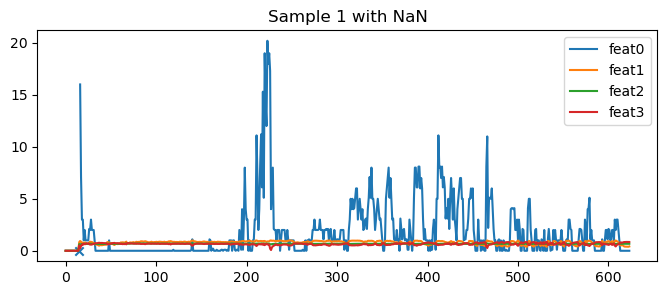

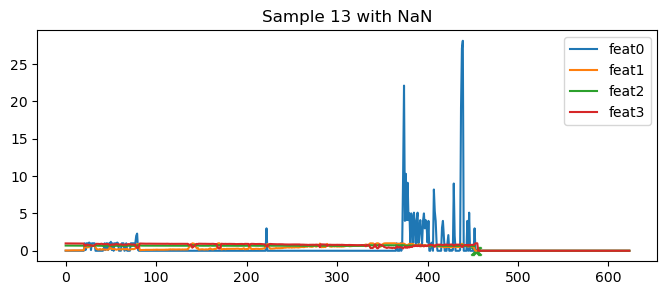

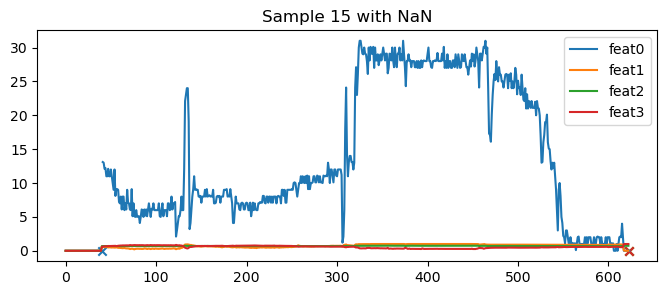

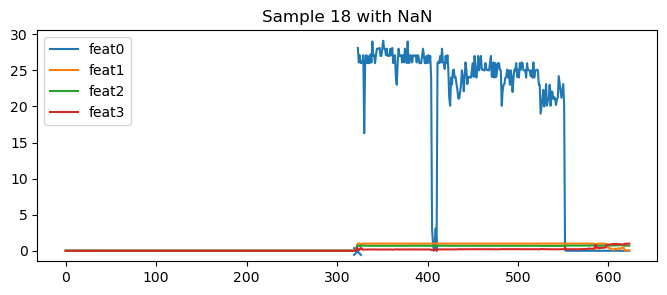

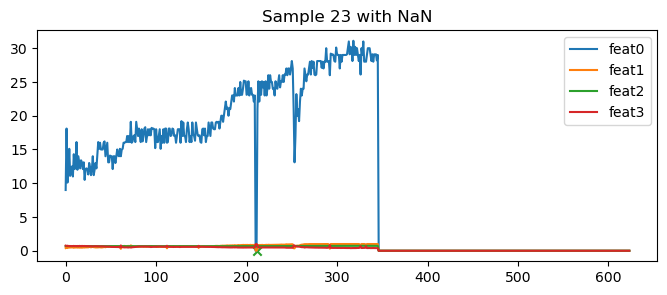

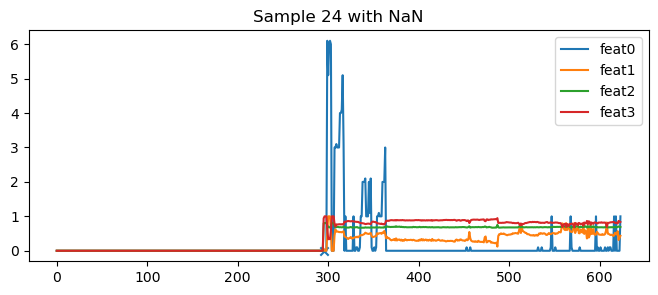

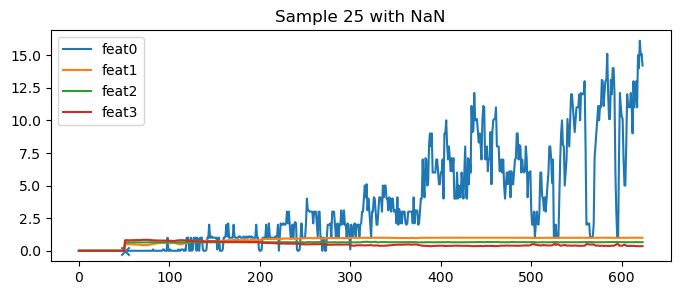

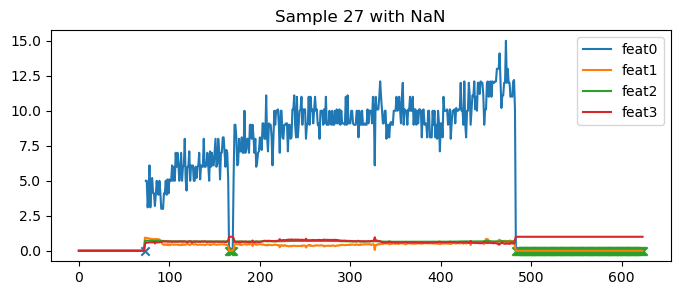

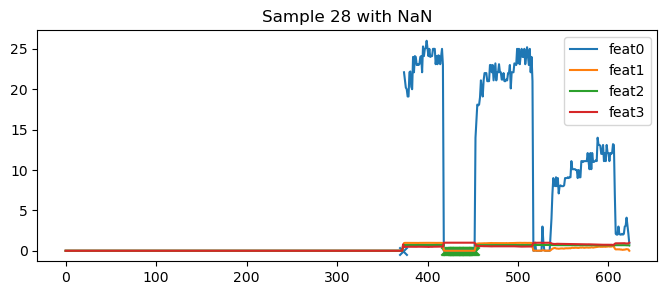

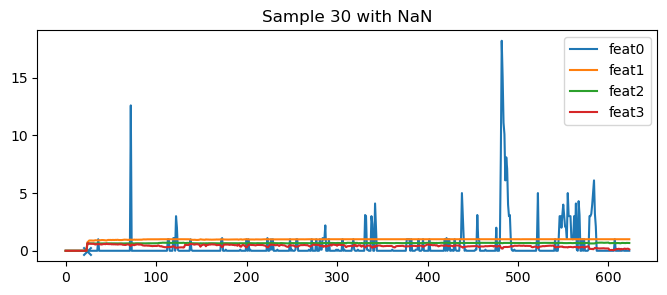

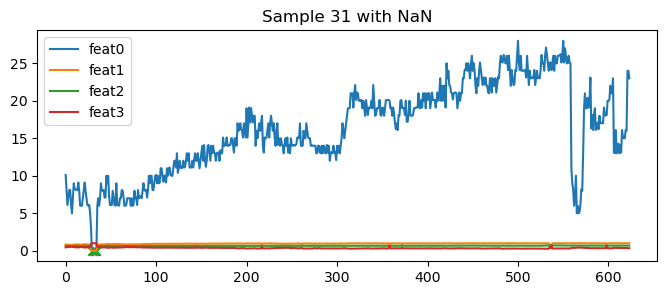

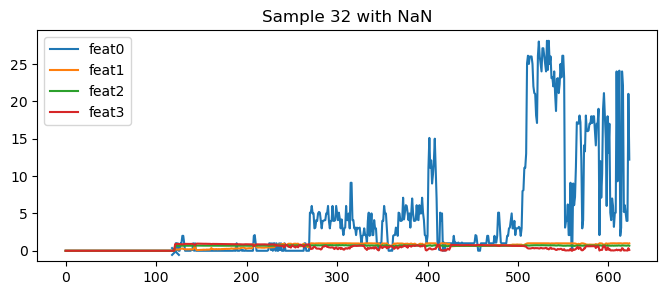

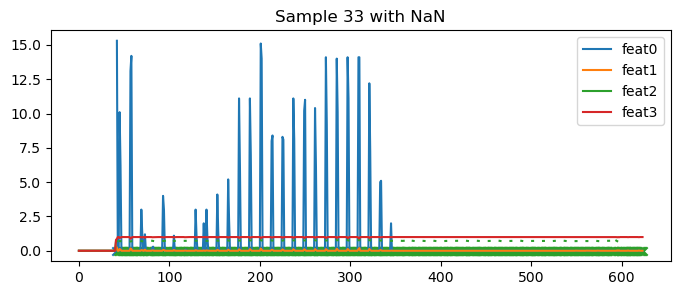

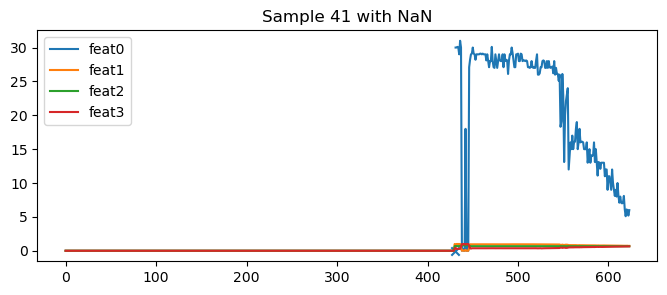

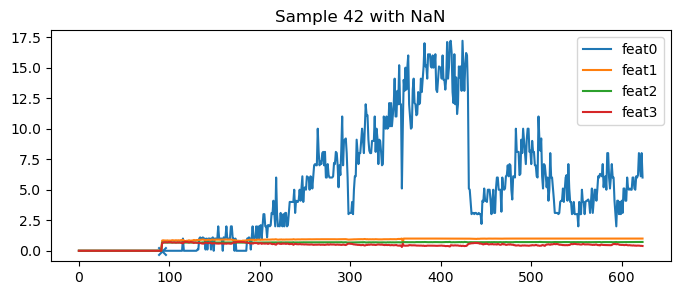

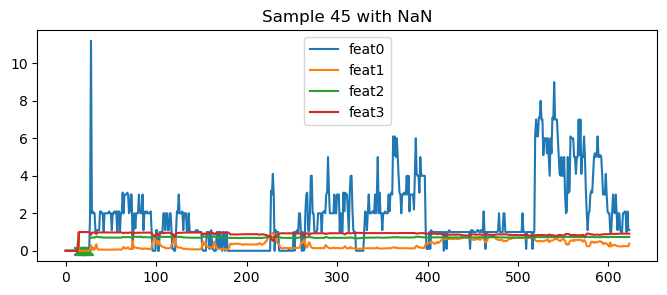

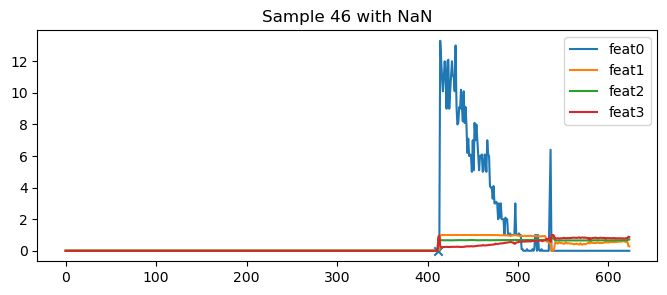

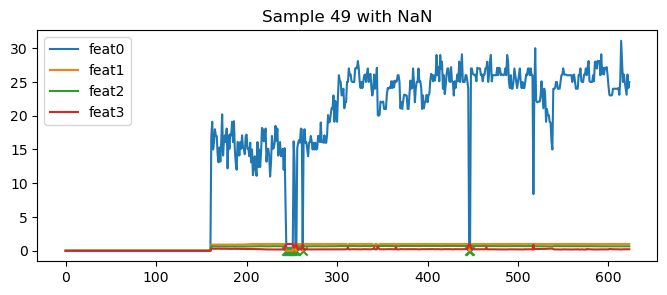

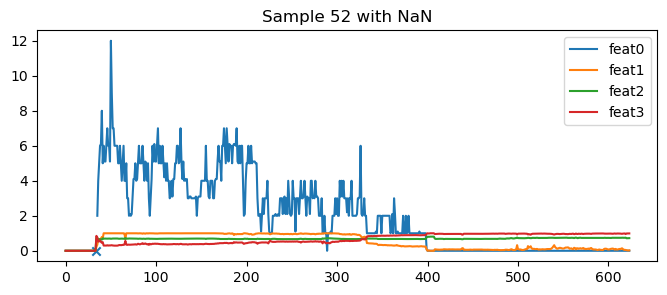

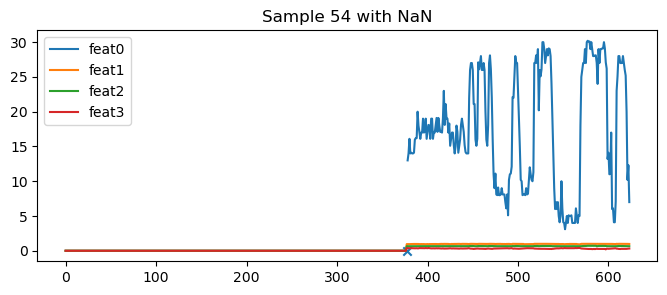

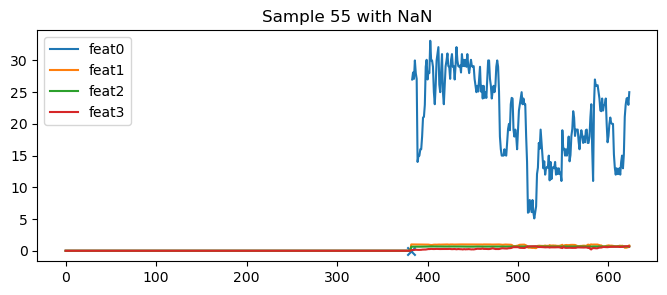

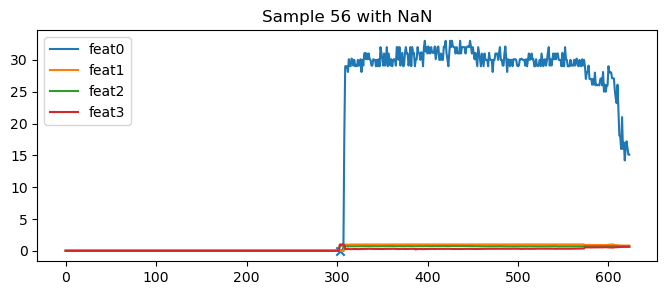

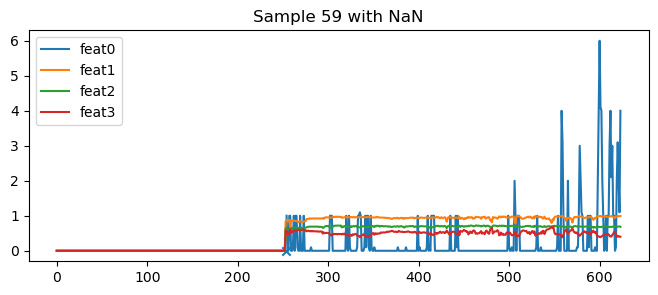

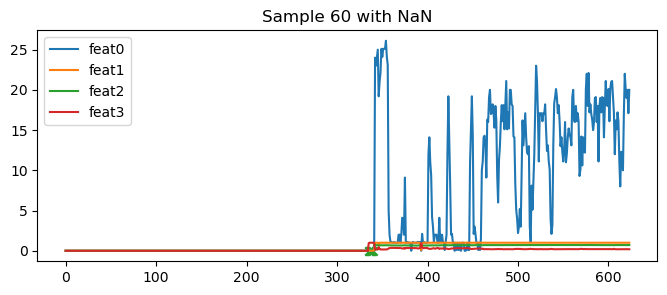

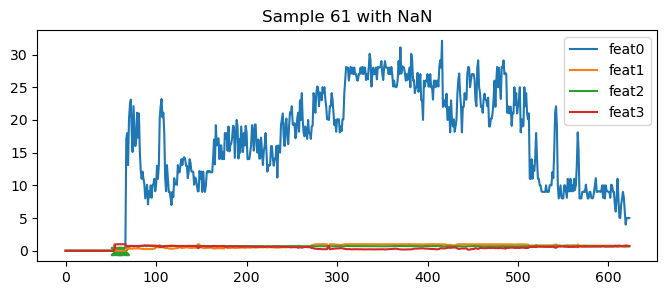

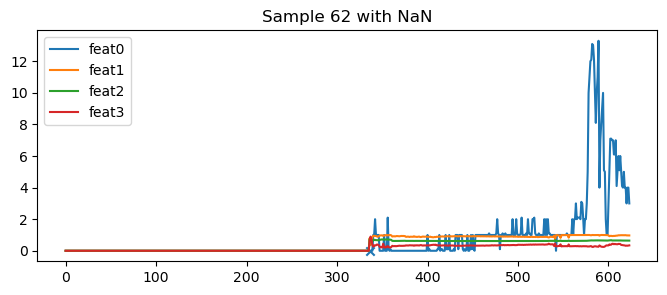

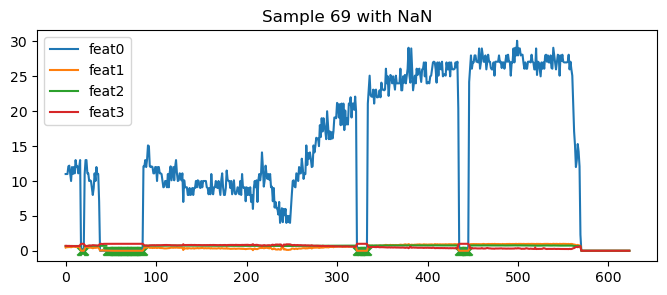

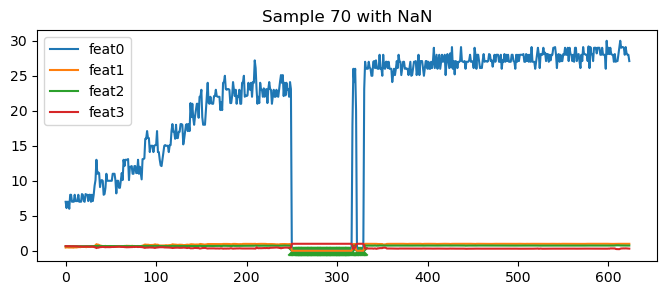

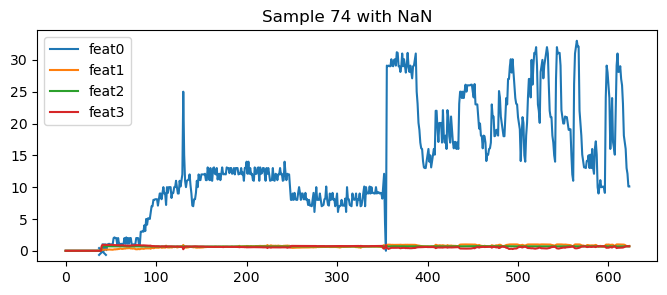

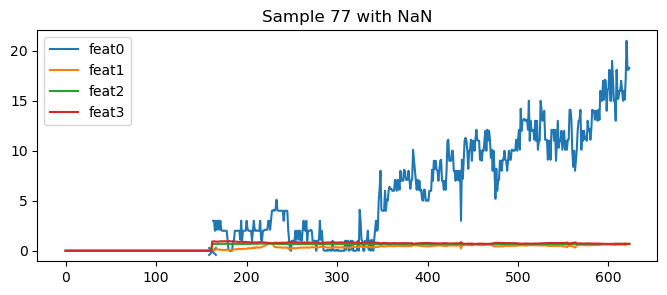

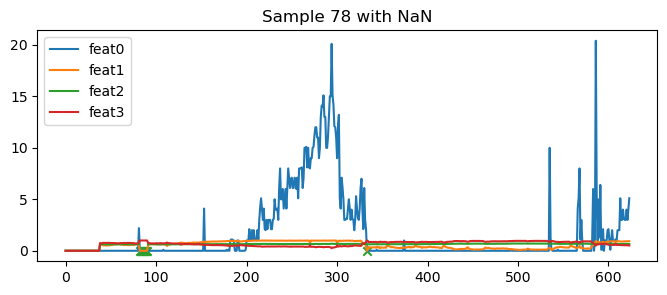

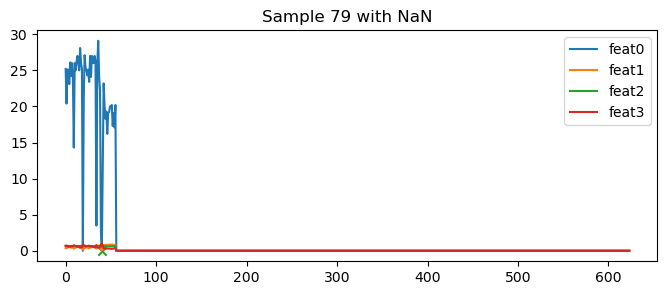

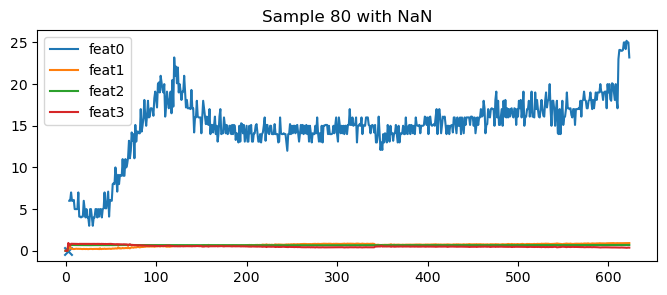

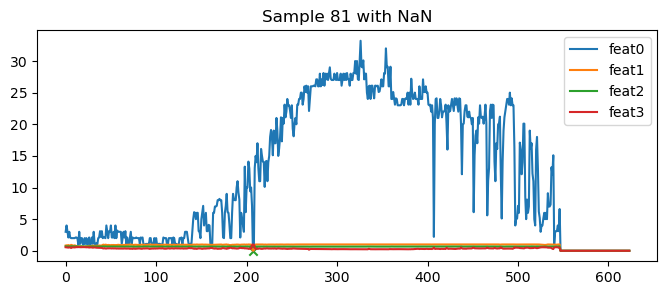

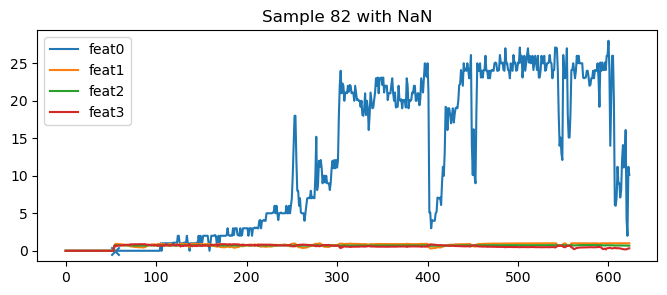

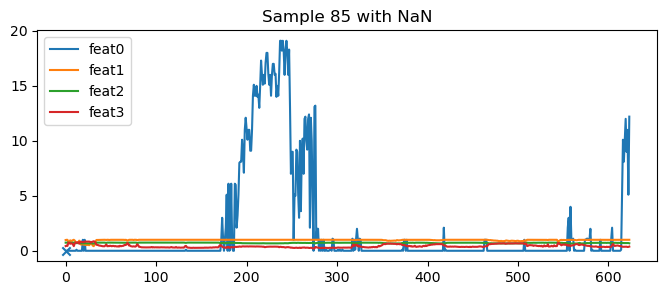

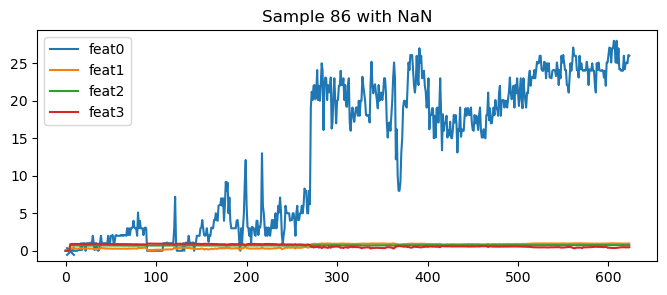

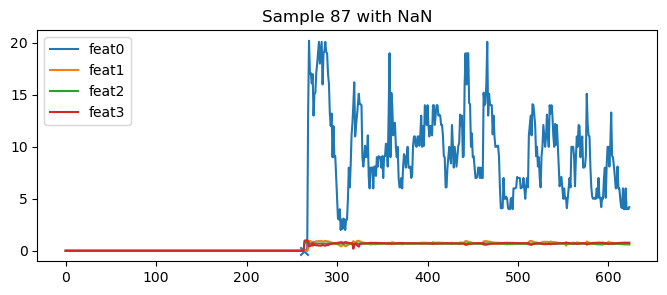

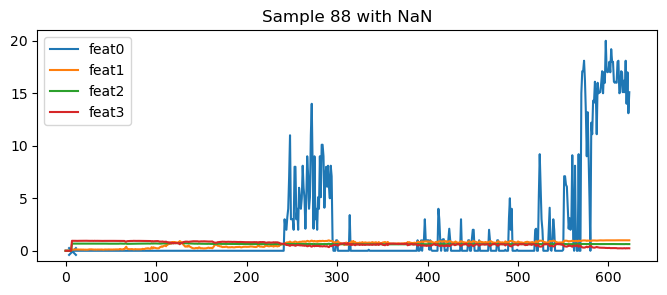

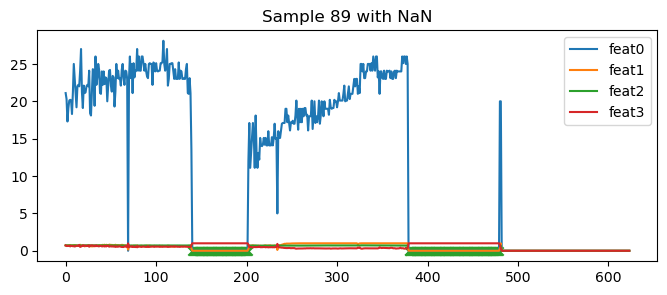

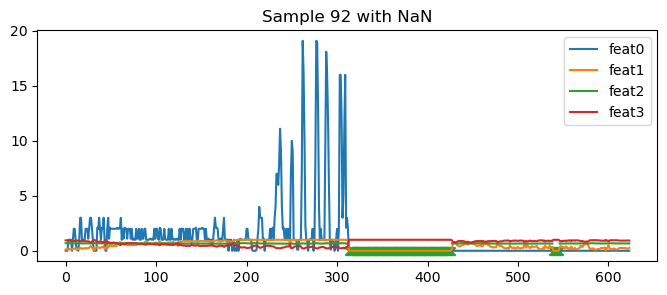

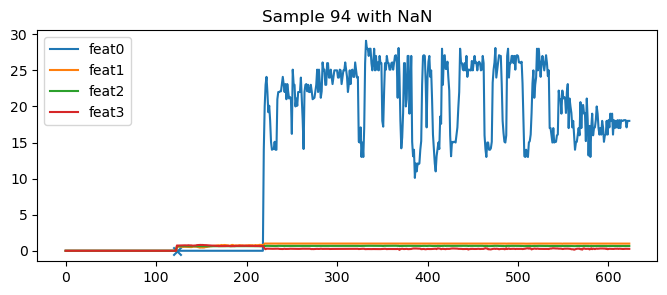

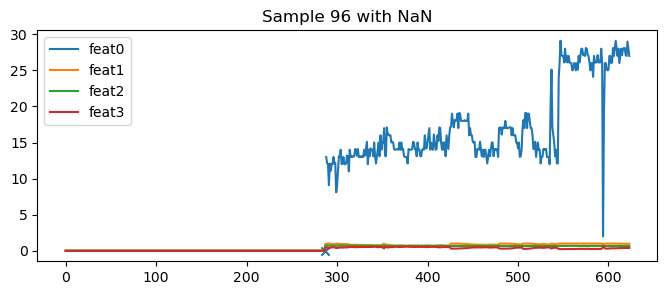

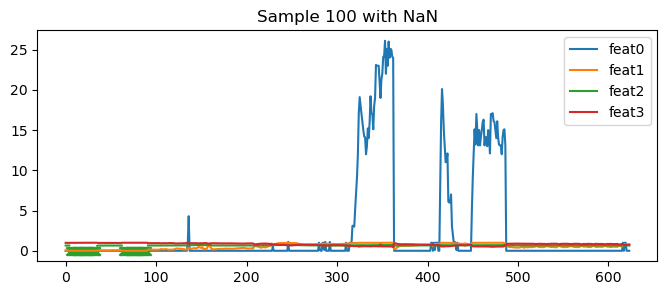

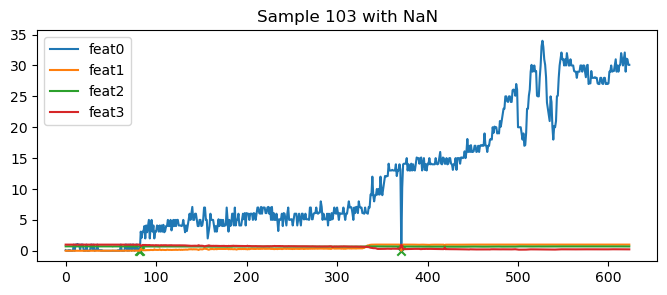

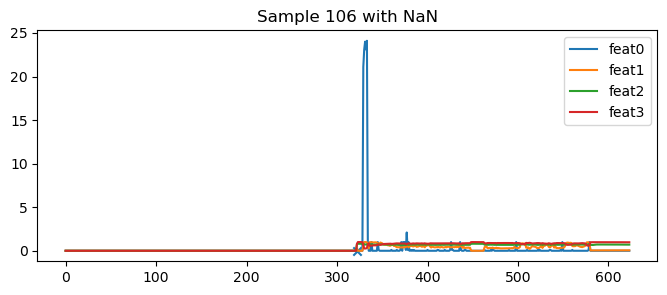

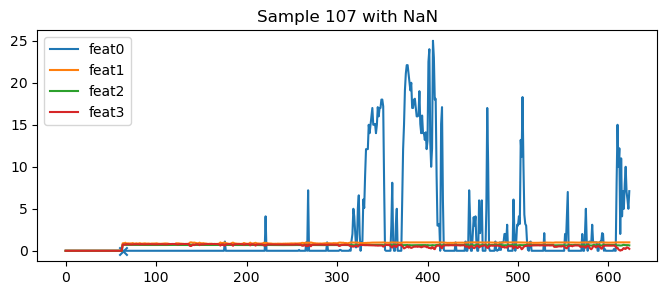

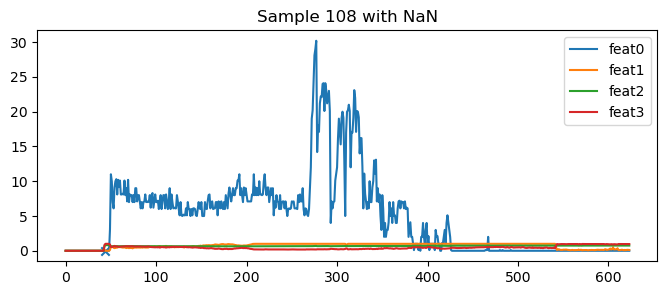

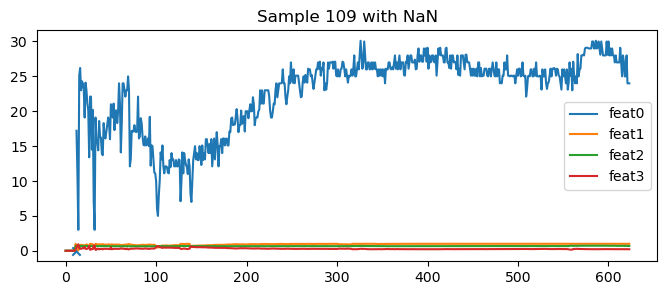

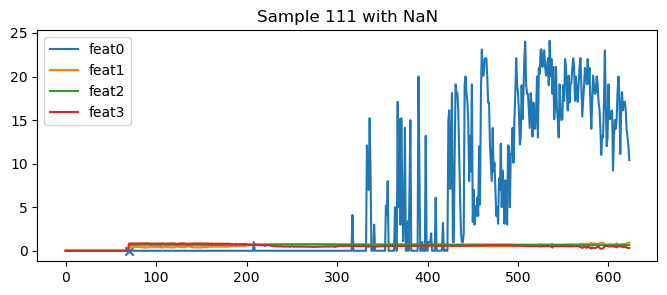

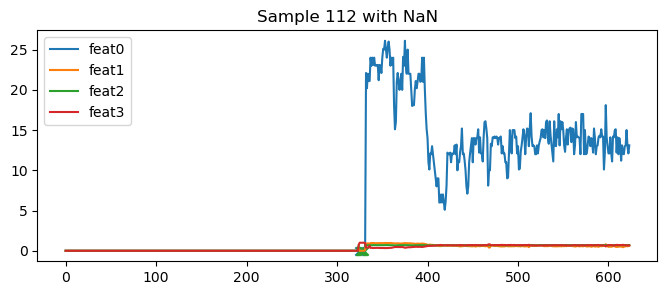

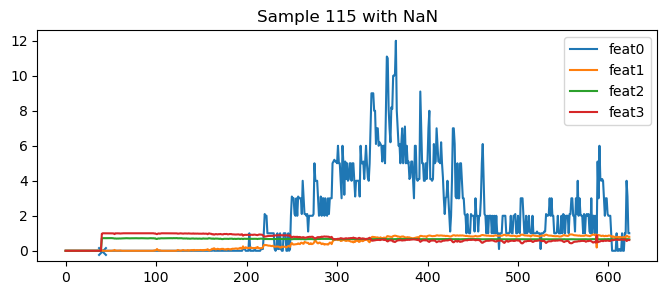

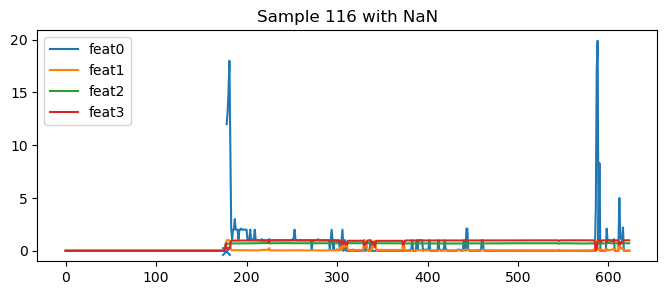

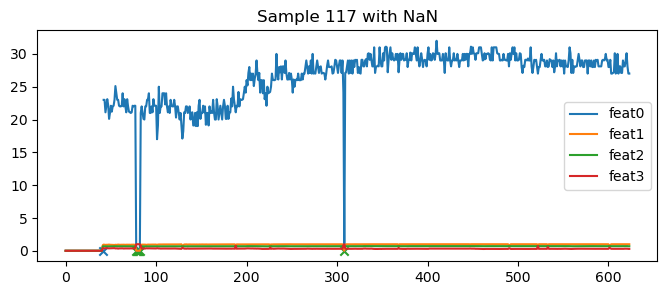

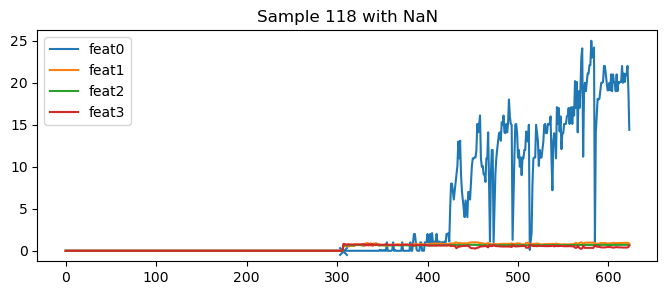

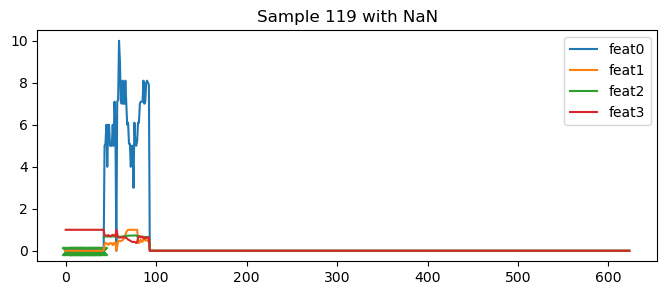

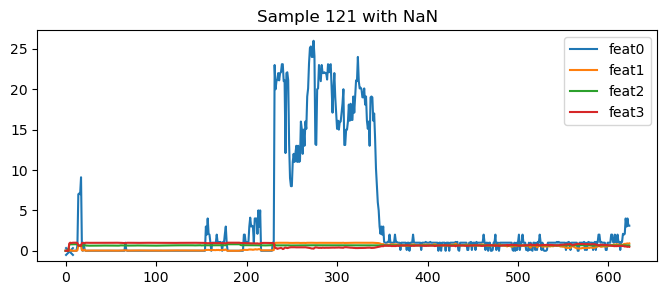

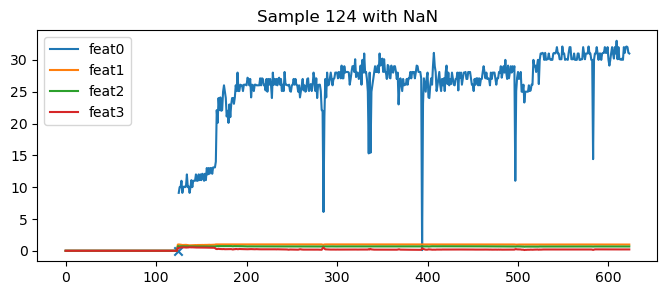

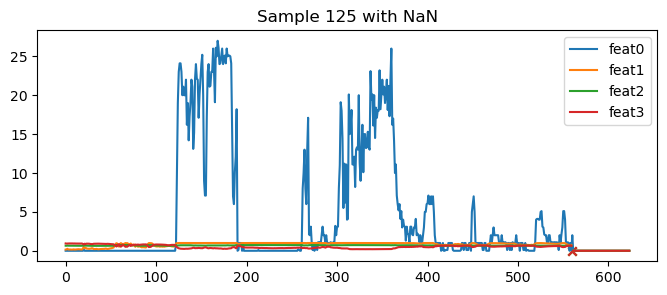

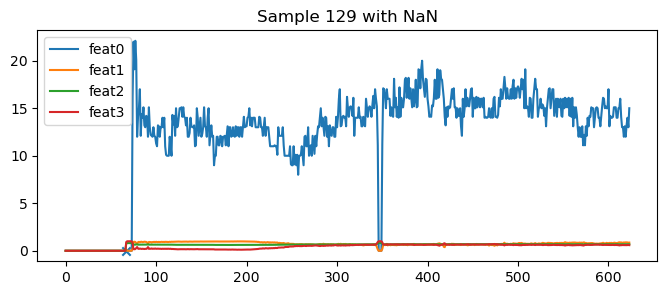

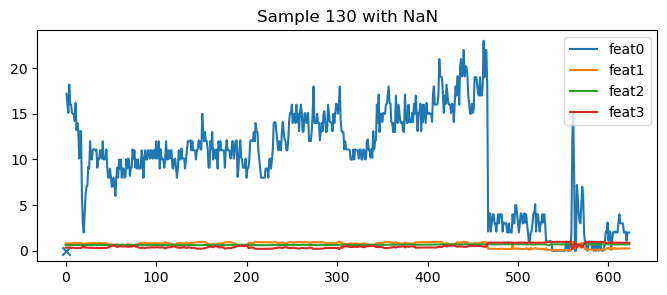

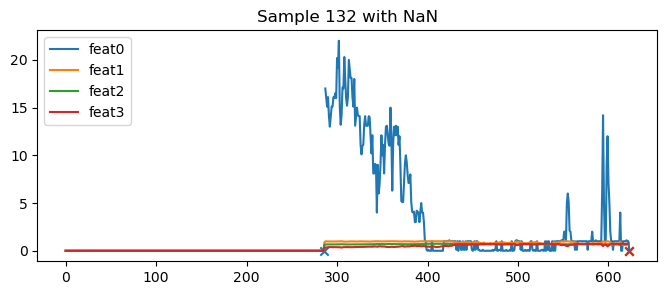

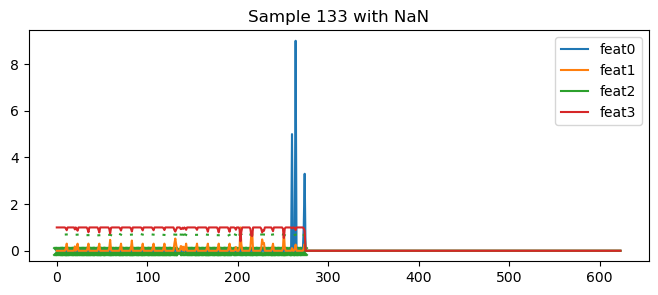

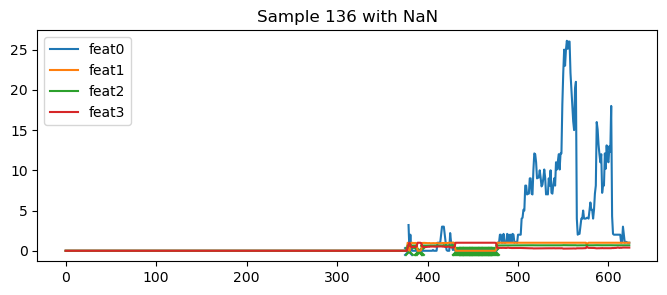

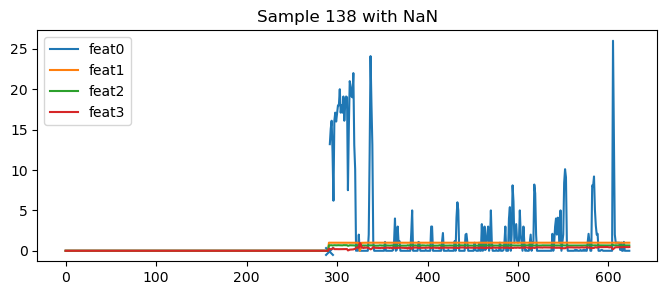

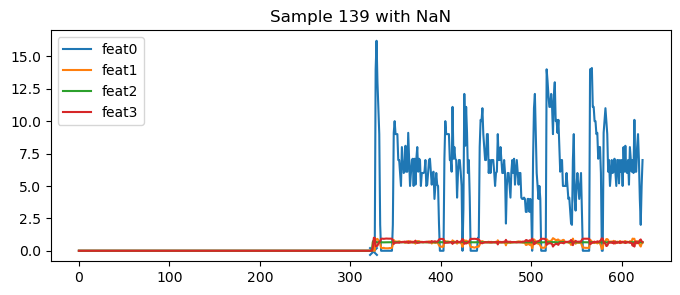

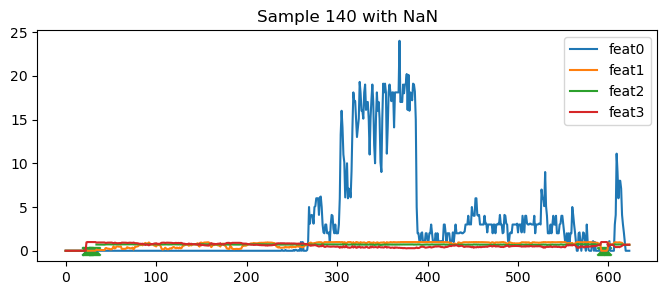

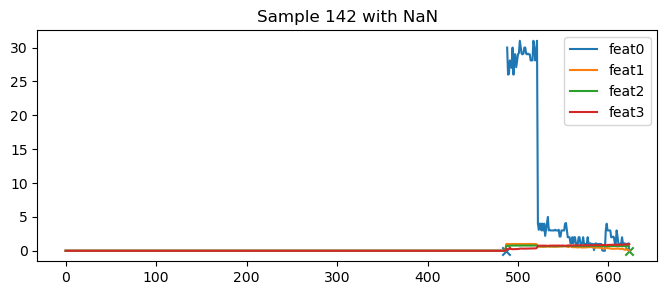

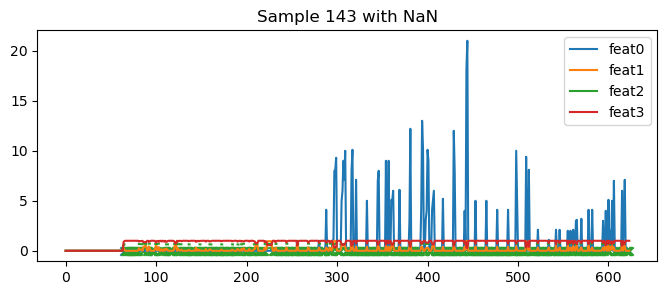

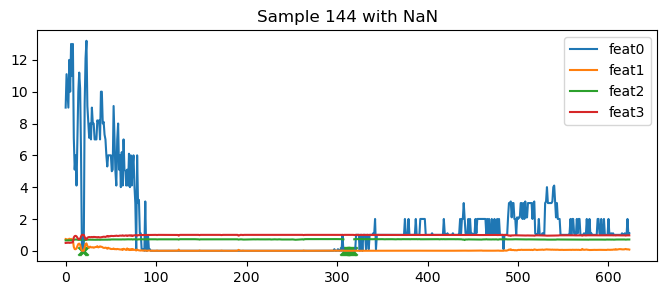

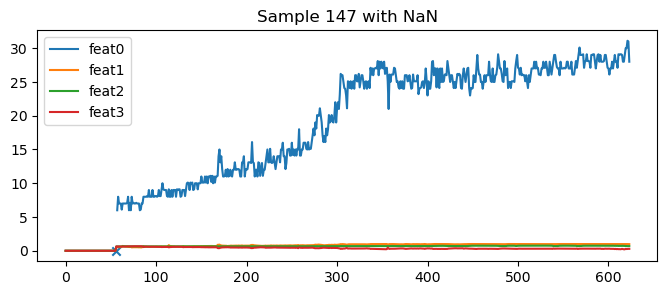

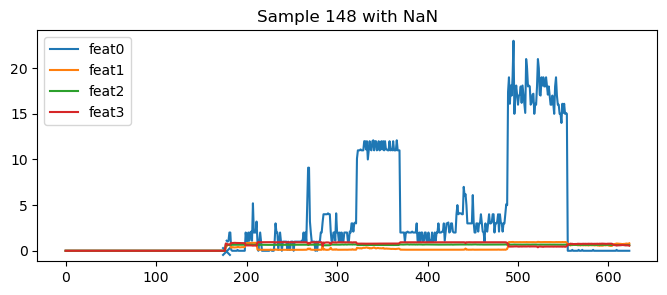

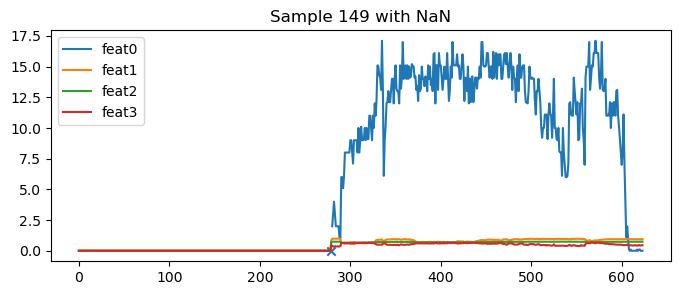

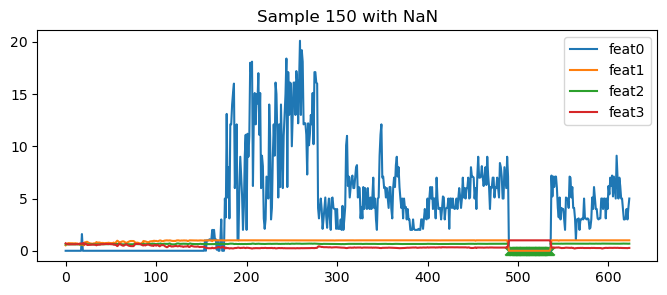

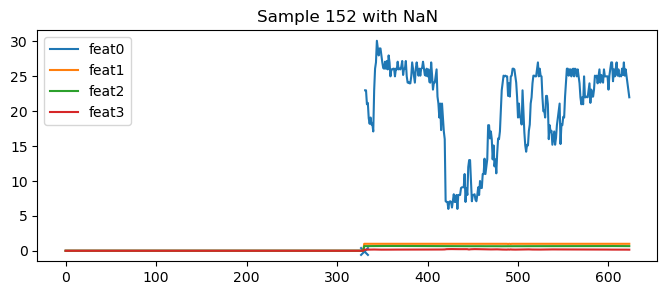

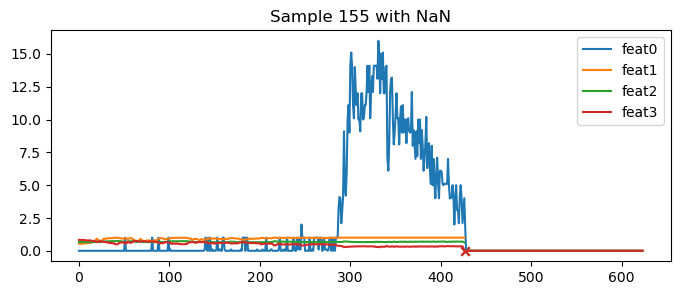

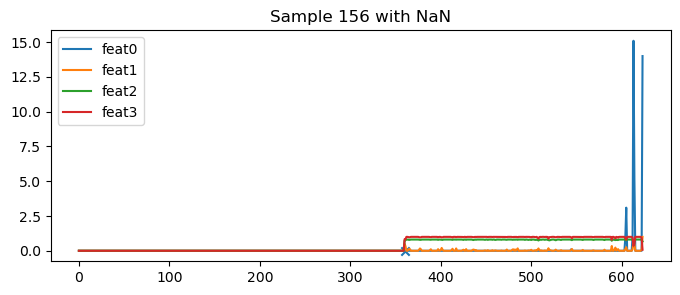

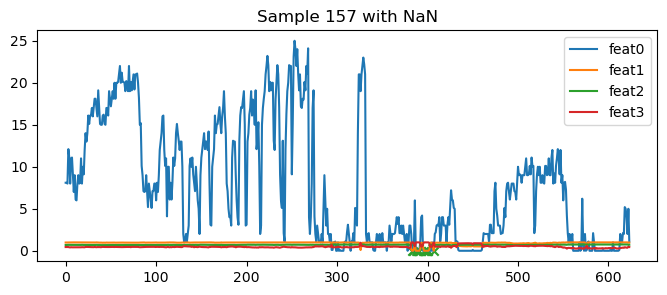

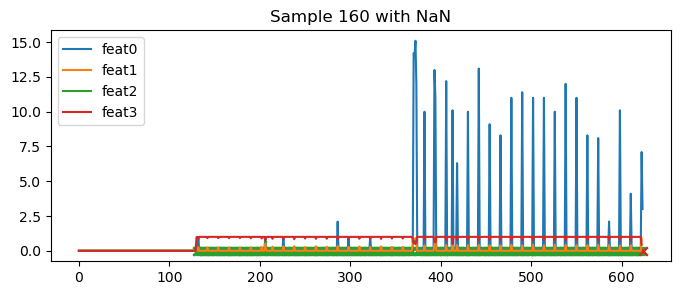

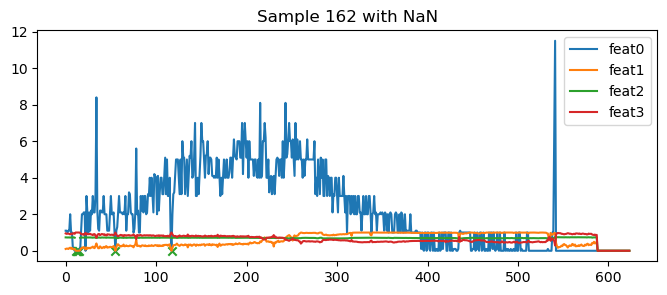

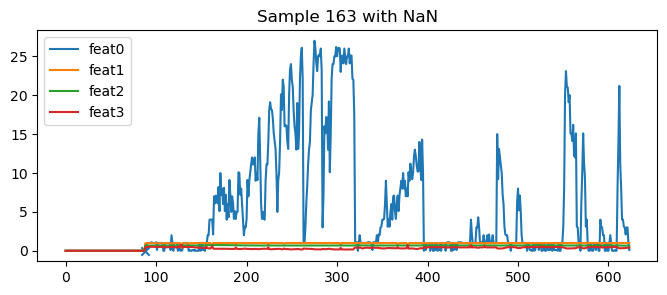

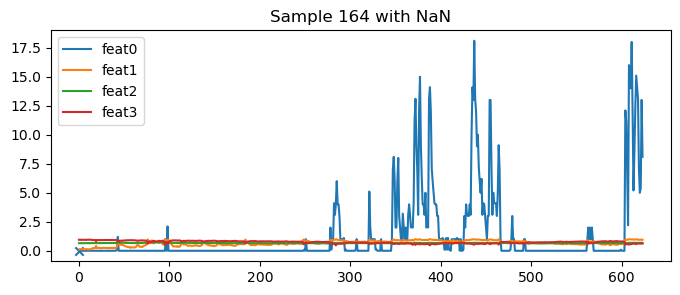

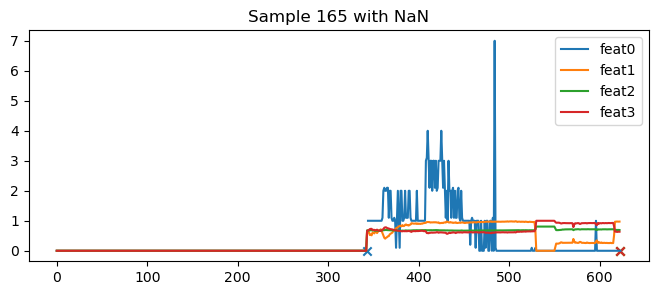

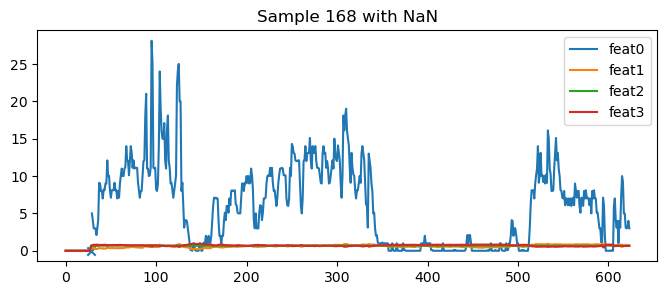

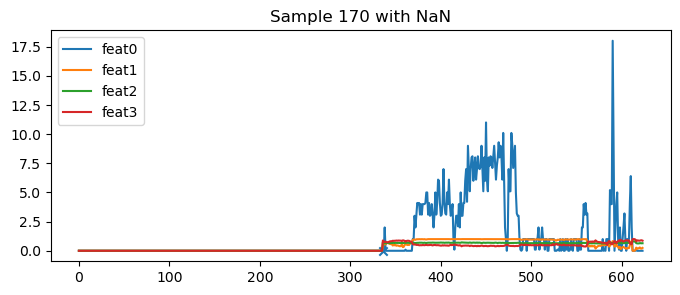

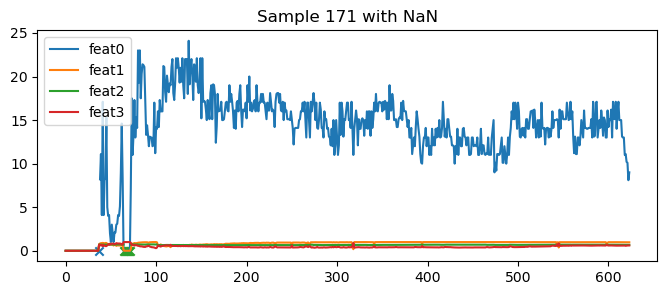

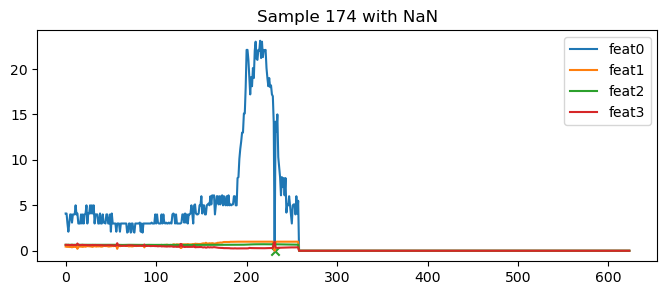

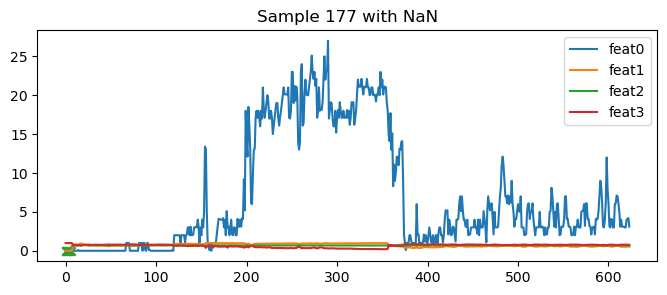

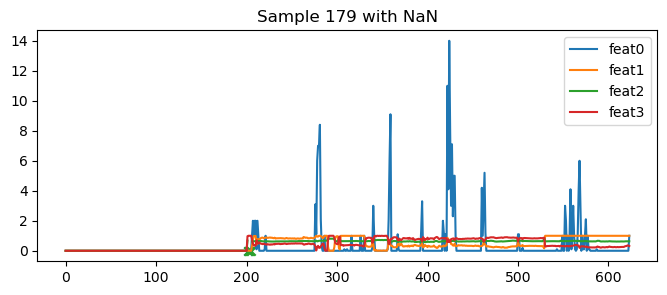

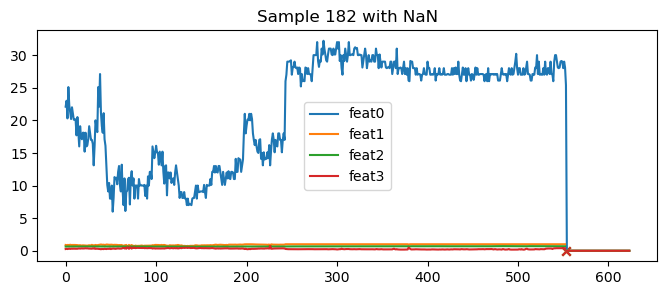

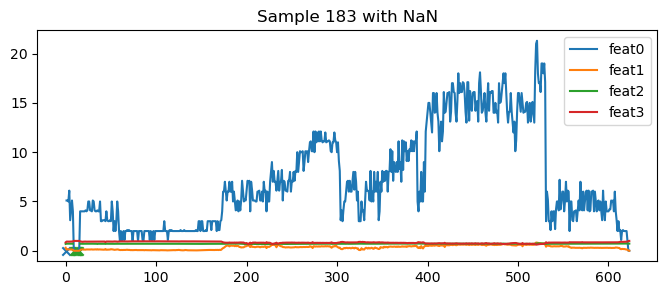

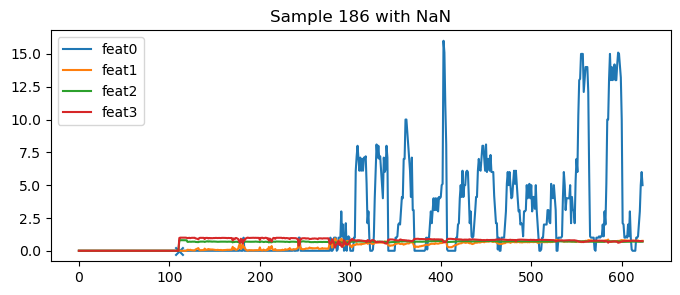

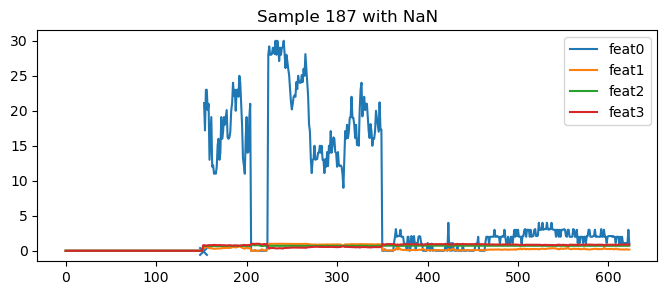

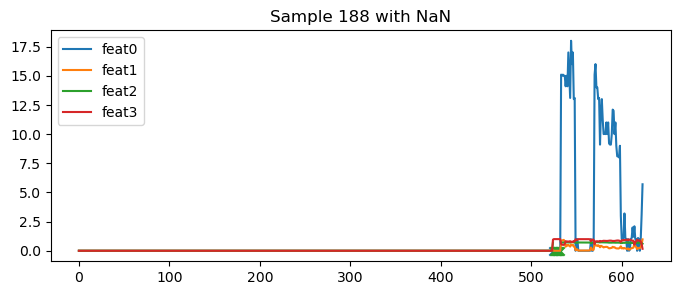

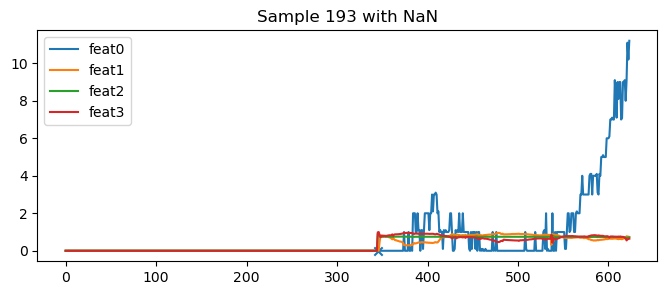

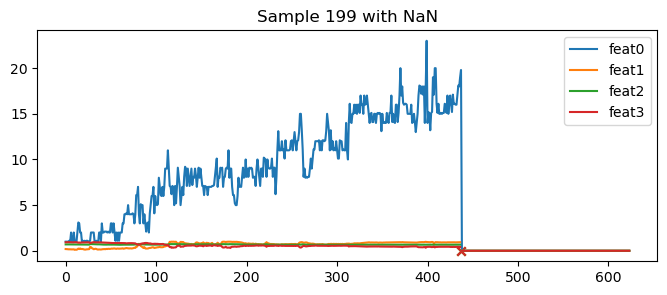

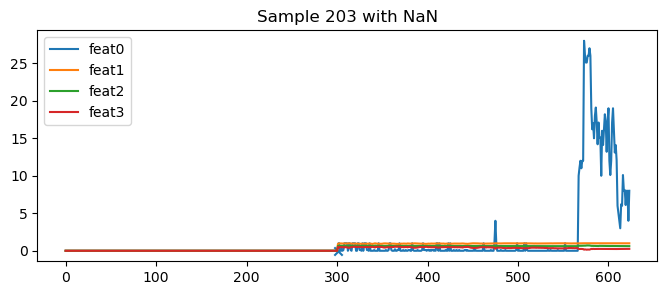

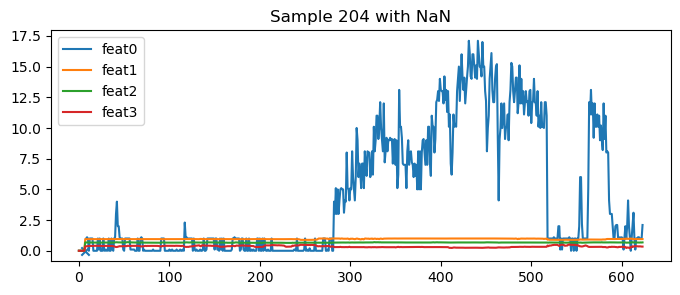

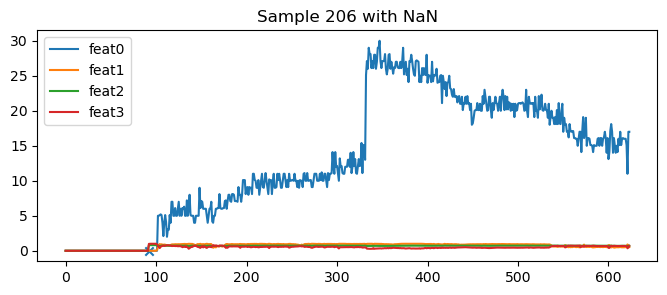

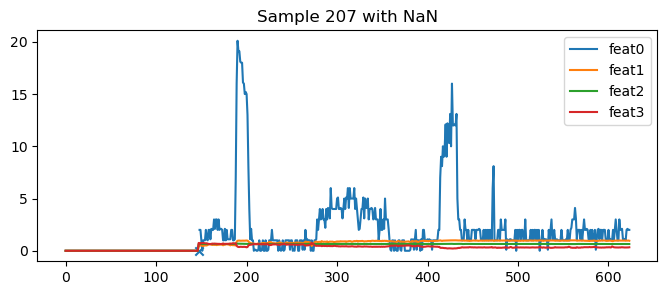

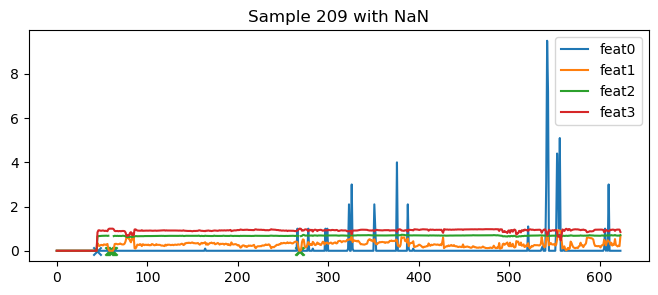

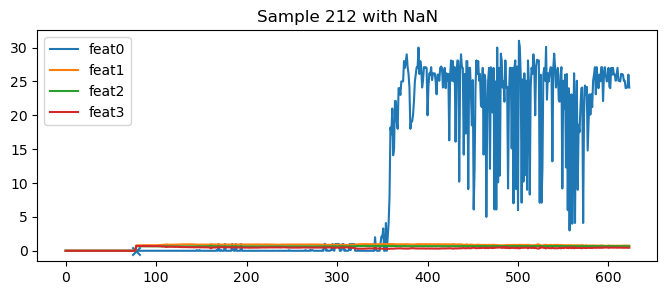

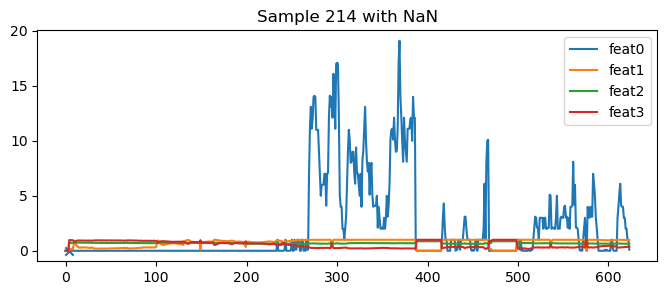

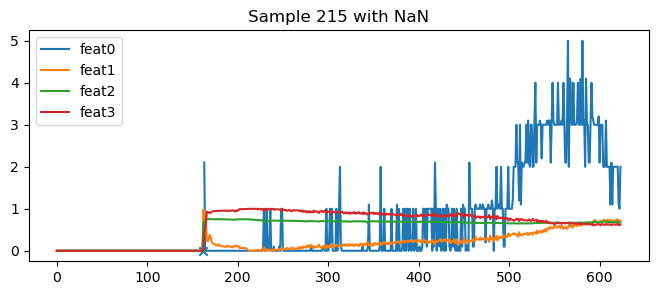

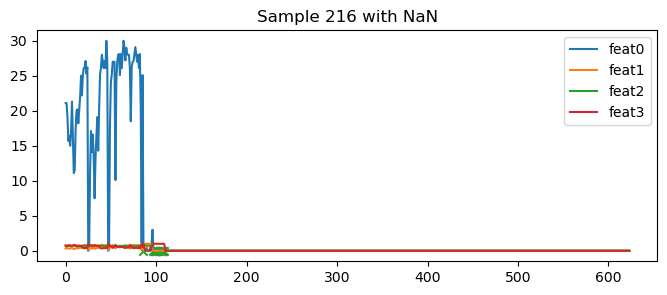

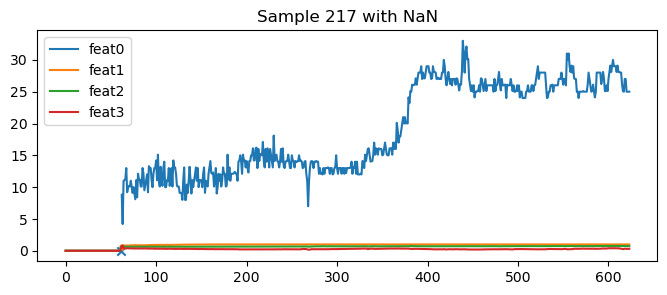

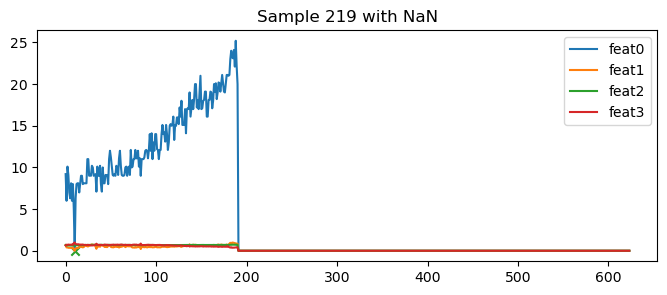

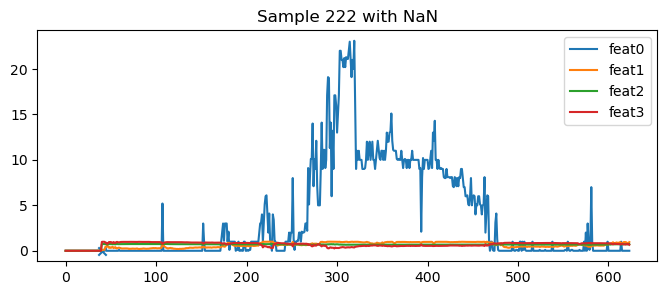

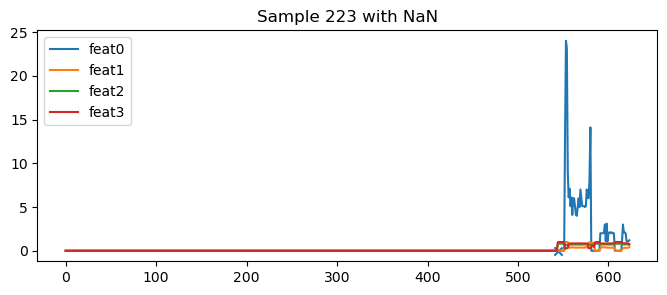

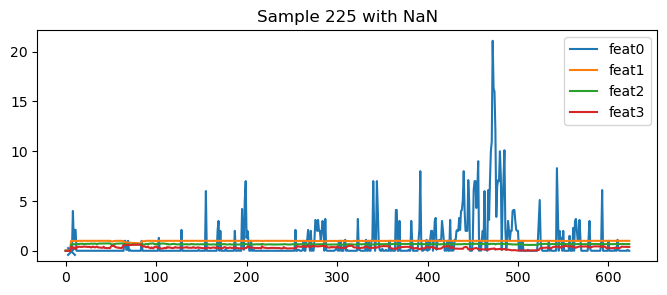

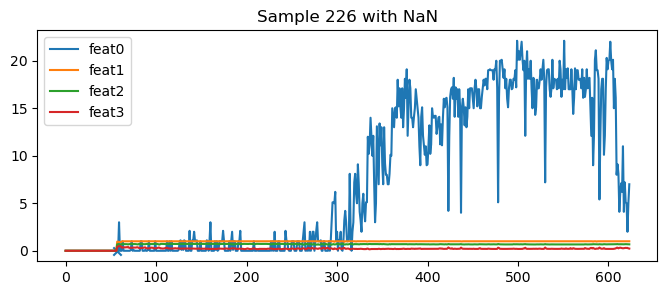

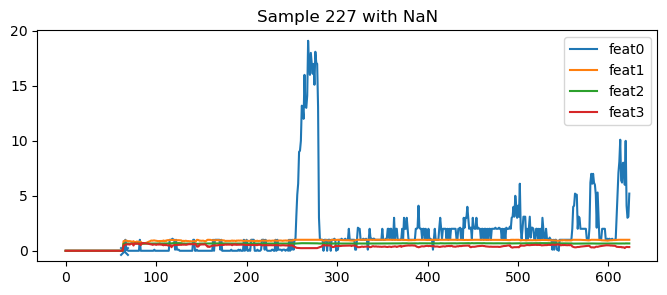

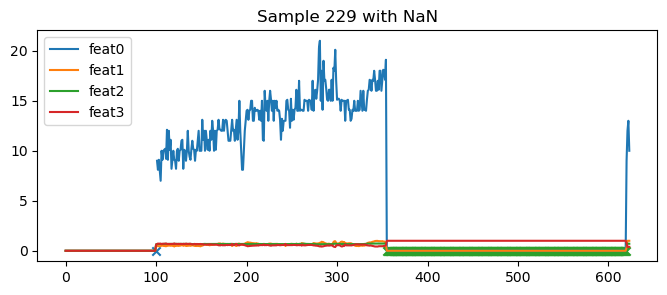

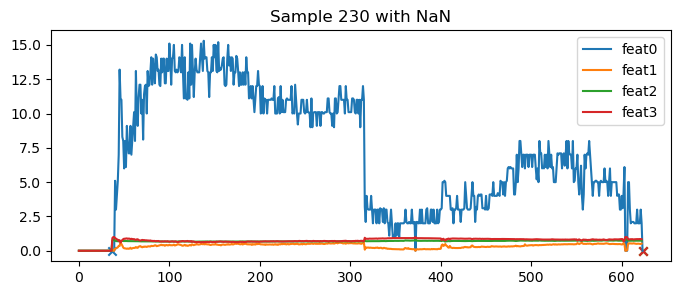

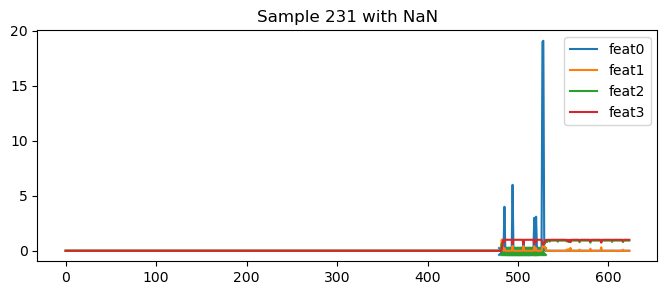

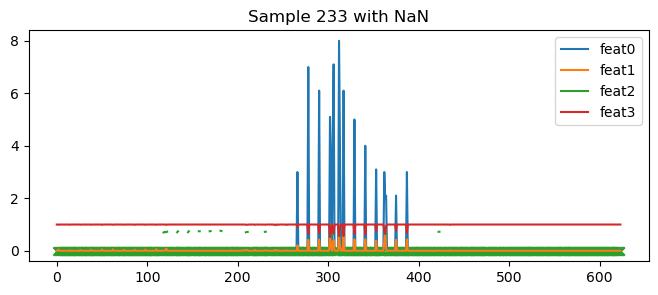

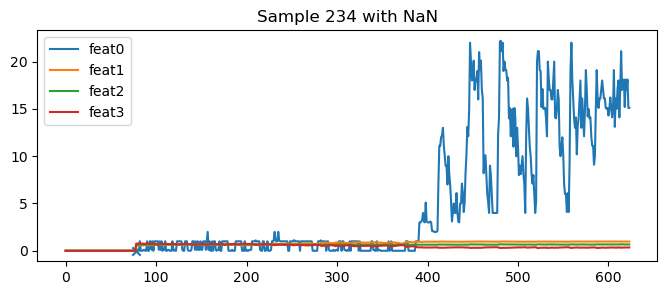

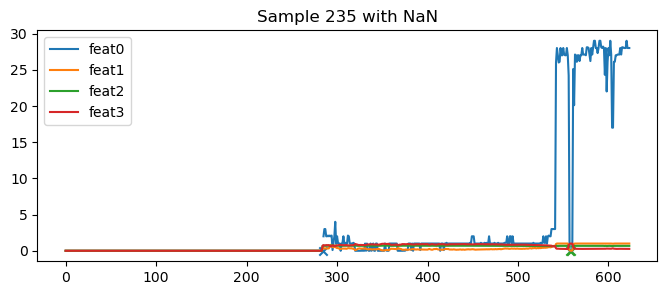

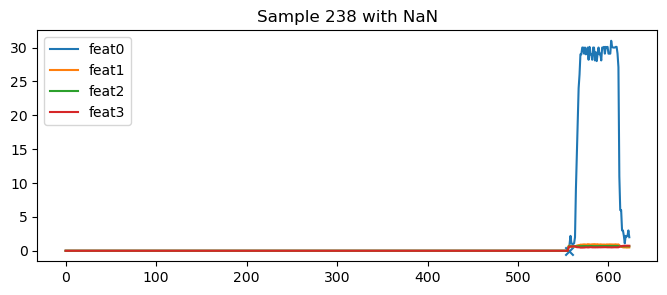

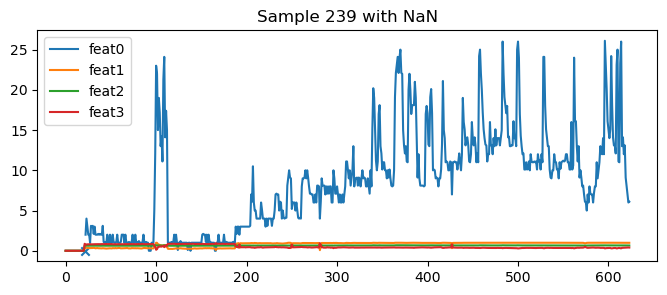

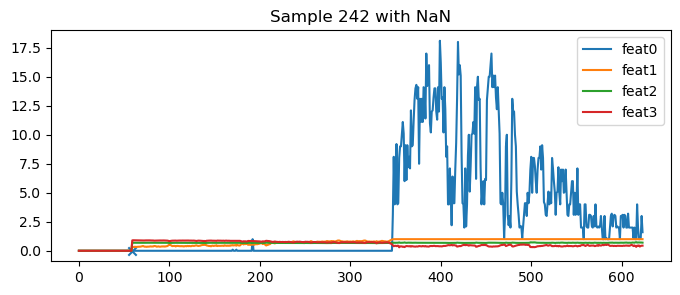

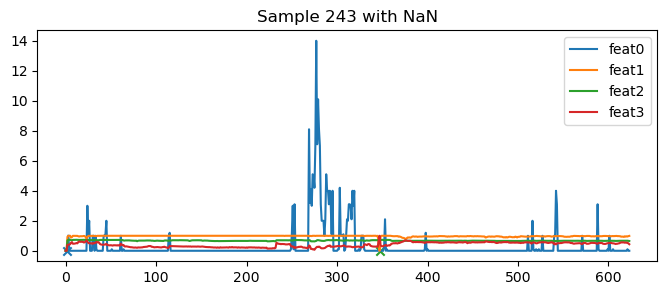

填充后：NaN count = 0 Inf count = 0


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import Counter

signals, labels, groups = [], [], []
for i in range(len(eeg_dataset)):
    sig_tensor, lab = eeg_dataset[i]        # 每次只有 ~1 ms
    signals.append(sig_tensor.numpy().T)    # (T', C)
    labels.append(lab)
    pid = eeg_dataset.valid_files[
              eeg_dataset.expanded_indices[i][0]
          ][0].split('.')[0]
    groups.append(pid)

X = np.stack(signals, dtype=np.float32)    # (244, T', C)
y = np.array(labels, dtype=np.float32)

# —— 3. 重建 groups 列表 —— 
# 由于 DataLoader shuffle=False，样本顺序等同于 eeg_dataset.expanded_indices 顺序
groups = [
    eeg_dataset.valid_files[e_idx][0].split('.')[0]
    for e_idx, _ in eeg_dataset.expanded_indices
]

print(f"After downsample: X.shape={X.shape}, y.shape={y.shape}, group count={len(groups)}")

# —— 4. 检测 NaN / Inf —— 
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: X 中存在无效值！")
    print("  NaN count:", np.isnan(X).sum())
    print("  Inf count:", np.isinf(X).sum())

nan_idxs = np.unique(np.where(np.isnan(X))[0])
print("含 NaN 的样本索引：", nan_idxs)

# 可视化包含 NaN 的样本
for idx in nan_idxs:
    series = X[idx]          # shape = (T', C)
    Tprime, C = series.shape
    plt.figure(figsize=(8, 3))
    for c in range(C):
        plt.plot(series[:, c], label=f"feat{c}")
        nan_pos = np.where(np.isnan(series[:, c]))[0]
        plt.scatter(nan_pos, np.zeros_like(nan_pos), marker='x')
    plt.title(f"Sample {idx} with NaN")
    plt.legend()
    plt.show()

# —— 5. 用 0 填充 NaN 和 Inf —— 
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print("填充后：NaN count =", np.isnan(X).sum(),
      "Inf count =", np.isinf(X).sum())


In [ ]:
# —— 2. 设置交叉验证和保存结果的容器 —— 
cv        = GroupKFold(n_splits=5)
cvscores  = []
auc_scores= []
preds_all = []

# —— 3. 在每个 fold 中重新构建模型、训练、评估 —— 
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # —— 3.1 定义 Keras 模型 —— 
    model = Sequential([
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(12, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # —— 3.2 训练 —— 
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,    # 可调整
        verbose=2
    )
    
    # —— 3.3 评估 —— 
    scores = model.evaluate(X_te, y_te, verbose=0)
    acc    = scores[1] * 100
    auc    = scores[2] * 100
    print(f"Accuracy: {acc:.2f}%, AUC: {auc:.2f}%")
    
    # —— 3.4 保存结果 —— 
    cvscores.append(acc)
    auc_scores.append(auc)
    
    # —— 3.5 预测并存储所有 fold 的输出 —— 
    preds = model.predict(X_te, verbose=0).flatten()
    preds_all.extend(preds)

# —— 4. 汇总所有 fold —— 
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")


--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
Epoch 1/20


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 - 7s - 283ms/step - accuracy: 0.7333 - auc: 0.5779 - loss: 0.6077
Epoch 2/20


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import numpy as np
import tensorflow as tf
from collections import Counter

# 假设 X, y, groups 都已准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores, preds_all = [], [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # 计算类别权重
    classes = np.unique(y_tr)
    weights = compute_class_weight('balanced', classes=classes, y=y_tr)
    class_weight = dict(zip(classes, weights))
    print(" class weights:", class_weight)
    
    # 定义模型
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # 训练时传入 class_weight
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,
        verbose=2,
        class_weight=class_weight
    )
    
    # 评估
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)
    
    preds_all.extend(model.predict(X_te).flatten())

# 汇总
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# 假设 X, y, groups 已经准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores = [], []

# 可选：定义 Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow(1 - p_t, gamma) * bce
    return loss_fn

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))

    # —— 1. 过采样少数类 —— 
    n_s, seq_len, n_feat = X_tr.shape
    X_flat = X_tr.reshape(n_s, -1)
    ros = RandomOverSampler(random_state=42)
    X_res_flat, y_res = ros.fit_resample(X_flat, y_tr)
    X_res = X_res_flat.reshape(-1, seq_len, n_feat)
    print(" after oversampling:", Counter(y_res))

    # —— 2. 定义模型（示例用双向 LSTM） —— 
    model = Sequential([
        Input(shape=(seq_len, n_feat)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(),  # 或者用 'binary_crossentropy'
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # —— 3. 训练 —— 
    model.fit(
        X_res, y_res,
        batch_size=8,
        epochs=20,
        verbose=2
    )

    # —— 4. 评估 —— 
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)

print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")
